## Predictive and Exploratory Analysis - Applicant and Hires Data

### Introduction

In this notebook, we will explore the Applicant and Hire datasets and then build a model to predict tenure category of hired hired employees.

### 1. Loading and Munging the Data

Our dataset consists of two comma separated files - one containing records for hired employees and the other for applicants. For this analysis we will load each file and merge matching records into one table. That is, for the prective analysis, we will only be using records from the two tables with matching user_ids. 

In [14]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">show/hide code</a>.''')

In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import sys, os
path = os.path.realpath('../src/')
sys.path.append(path)

from data_load_transform import DataLoadTransform
from visuals import *
from model import Model


In [51]:
dlt = DataLoadTransform()
df_applicants_hires = dlt.init_load_data()

### 2. Data Exploration
#### Applicant to Hire Ratio

We define Application to Hire Ratio of an Organization as the total number of applicants divided by the total number of hires for each organization. We found the following application-to-hire ratios for each of the organizations in our data. 

,client_name,total_applied,client,total_hired,applicant_hire_ratio
3,client9,453,client9,696,1.536424
0,client10,2123,client10,961,0.452661
2,client4,676,client4,187,0.276627
1,client11,6701,client11,1674,0.249813


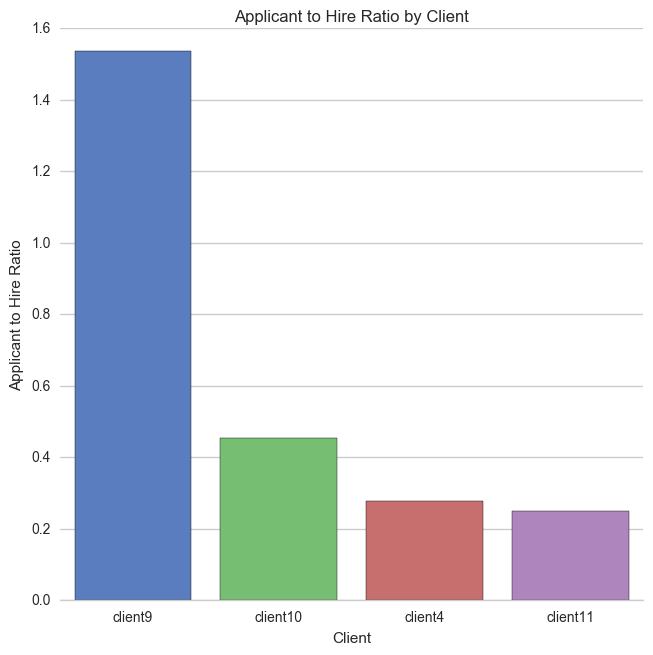

In [3]:
hires_by_client = dlt.hires[['client', 'user_id']].groupby(by='client').count().reset_index()\
                .rename(columns={'user_id': 'total_hired'})
applicants_by_client = dlt.applicants[['client_name', 'user_id']].groupby(by='client_name').count().reset_index()\
                .rename(columns={'user_id': 'total_applied'})
applied_hired_client = applicants_by_client.merge(hires_by_client, left_on='client_name', right_on='client', how='left')
applied_hired_client['applicant_hire_ratio'] = applied_hired_client.total_hired.astype('float64') / applied_hired_client.total_applied
applied_hired_client.sort_values(by='applicant_hire_ratio', ascending=False, inplace=True)

plot_group(applied_hired_client, x='client_name', y='applicant_hire_ratio', kind='bar', 
           title='Applicant to Hire Ratio by Client', xlab='Client', ylab='Applicant to Hire Ratio')
applied_hired_client

In this figure, we can see that client9 has the highst applicant to hire ratio, from among all the clients in our data. This is odd because the figure suggests that client9 has more employees than applicants which doesn't make sense since it is rare that a company has employees that never applied for the position they hold. But we know from the metadata that some applicants were hired before organizations began collecting the applicant data we have right now. Therefore we can explain client9's unusual applicant-to-hire ratio as a case where the client began collecting such applicant data that we have now, after it hired most of its staff in the hired dataset.

Looking at the rest of the organizations in the plot, we can see that client10 has a solid applicant-to-hire ratio of _45%_ while client4 and client11 with _27%_ and _25%_ respectively.

#### Attrition Rate
##### 3 Month Attrition Rate
3 Month Attrition rate is defined here as the rate at which hired applicants leave the organization with less 90 days tenure. This will include all employees who are currently not employed with a tenure less than 3 months.

Organizations with the highest attrition rates (within the first 3 months of employment) are shown by the figure below.

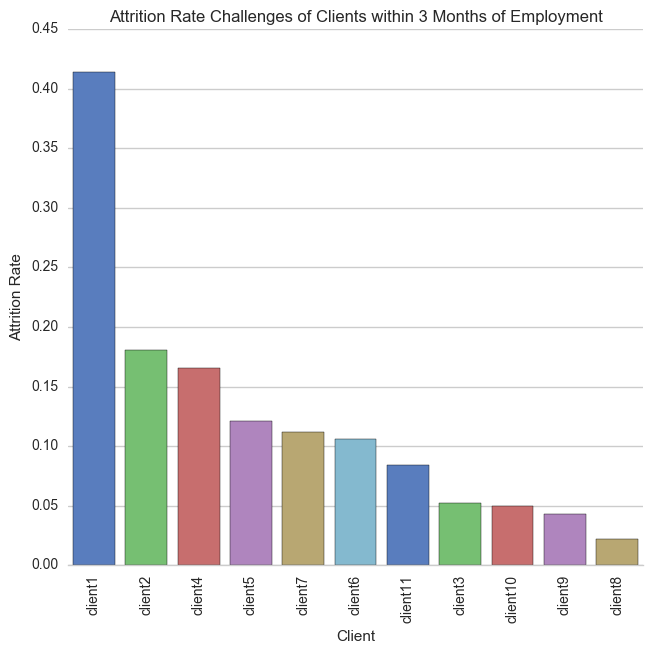

In [18]:
# The following will create two dataframes to group all hires by client and all 3 month attritions
attrition_3m_df = dlt.hires.query("tenure_length < 90 and currently_employed == 'N'")[['client', 'tenure_length']]\
                    .groupby(by='client').count().reset_index().rename(columns={'tenure_length': 'total_attrited'})

# merging the two below will allow us to calculate the rate of attrition for each client
# by dividing the total 3 month attritions of each client with the total number of hired employees by the client
attrition_3m_df = attrition_3m_df.merge(hires_by_client, on='client', how='inner')
attrition_3m_df['attrition_rate'] = np.round(attrition_3m_df.total_attrited / attrition_3m_df.total_hired, 4)
attrition_3m_df.sort_values(by='attrition_rate', ascending=False, inplace=True)
plot_group(attrition_3m_df, x='client', y='attrition_rate', kind='bar', rotation=90,
           title='Attrition Rate Challenges of Clients within 3 Months of Employment', xlab='Client', ylab='Attrition Rate')



### 3. Data Analysis
##### 6 Month Attrition Rate
6 Month Attrition rate is defined here as the rate at which hired applicants leave an organization between 165 and 195 days. This will include all employees who are currently not employed with a tenure of 5.5 - 6.5 months.

Here is a plot of all 6 Month attrition rates across all the job categories, sorted from highest to lowest.

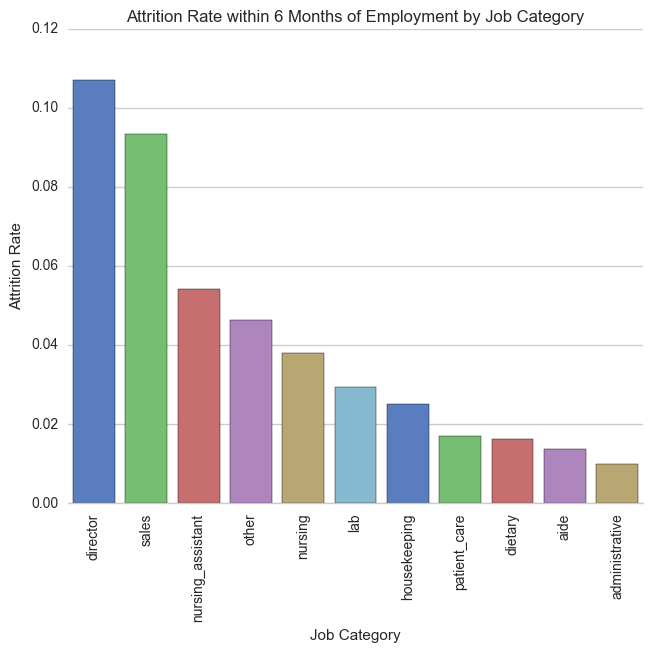

In [20]:
# The following will create two dataframes to group all hires by job category and all 6 month attritions
hires_by_jcategory = dlt.hires[['hire_job_category', 'user_id']].groupby(by='hire_job_category').count().reset_index()\
                .rename(columns={'user_id': 'total_hired'})
m6_attrition_df = dlt.hires.query("tenure_length > 165 and tenure_length < 195 and currently_employed == 'N'")[['tenure_length', 'hire_job_category']]\
                    .groupby(by='hire_job_category').count().reset_index().rename(columns={'tenure_length': 'total_attrited'})

# merging the two below will allow us to calculate the rate of attrition for each job category 
# by dividing the total 6 month attritions of each job category with the total number of hired employees for the category 
m6_attrition_df = m6_attrition_df.merge(hires_by_jcategory, on='hire_job_category', how='inner')
m6_attrition_df['attrition_rate'] = np.round(m6_attrition_df.total_attrited / m6_attrition_df.total_hired, 4)
m6_attrition_df.sort_values(by='attrition_rate', ascending=False, inplace=True)
plot_group(m6_attrition_df, x='hire_job_category', y='attrition_rate', kind='bar', rotation=90,
           title='Attrition Rate within 6 Months of Employment by Job Category', xlab='Job Category', ylab='Attrition Rate')

Above we can see that the top two job categories with the most 6 month attrition rates are _director_ and _sales_ at _11%_ and _9%_ respectively with _nursing assistant_ further behind the two at _5%_.

We can further analyze this by looking at 6 month attrition rate across all organizations and job categories. Looking at the heatmap below, we can see that certain organizations are faced with high attrition rates from specific job categories. 

For example, client3 has a high 6 month attrition rate of _18%_ in its staff of _nursing assistants_ while client8 is faced with a 6 month attrition rate of 20% in its nursing staff.

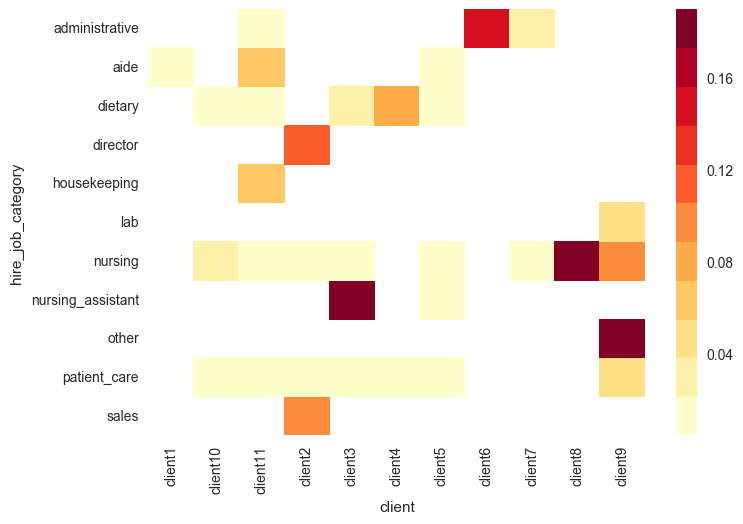

In [25]:
# The following will create two dataframes to group all hires by job category and all 6 month attritions
hires_by_jcategory = dlt.hires[['hire_job_category', 'user_id', 'client']].groupby(by=['hire_job_category', 'client']).count().reset_index()\
                .rename(columns={'user_id': 'total_hired'})
client_m6_attrition_df = dlt.hires.query("tenure_length > 165 and tenure_length < 195 and currently_employed == 'N'")[['tenure_length', 'client', 'hire_job_category']]\
                    .groupby(by=['hire_job_category', 'client']).count().reset_index().rename(columns={'tenure_length': 'total_attrited'})

# merging the two below will allow us to calculate the rate of attrition for each job category 
# by dividing the total 6 month attritions of each job category with the total number of hired employees for the category 
client_m6_attrition_df = client_m6_attrition_df.merge(hires_by_jcategory, on=['hire_job_category', 'client'], how='inner')
client_m6_attrition_df['attrition_rate'] = np.round(client_m6_attrition_df.total_attrited / client_m6_attrition_df.total_hired, 4)
client_m6_attrition_df.sort_values(by=['attrition_rate', 'client'], ascending=False, inplace=True)

plot_heatmap(client_m6_attrition_df, x='hire_job_category', y='attrition_rate', group='client', rotation=90)


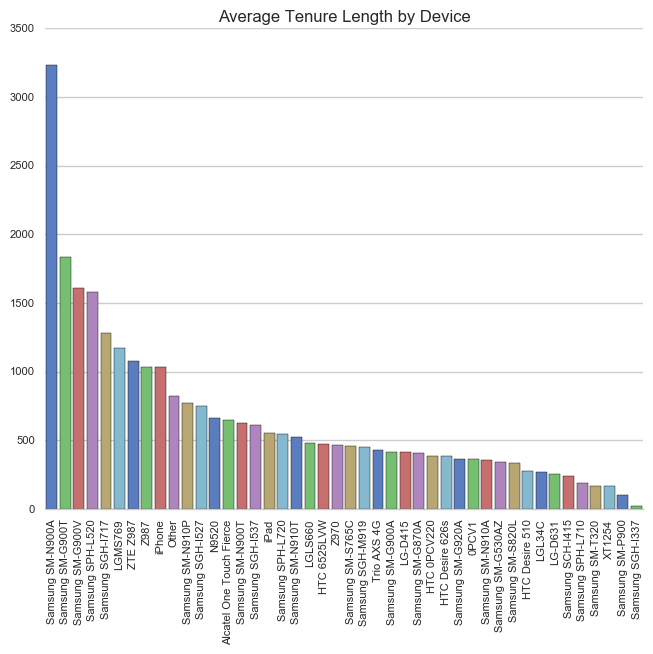

In [6]:
by_device = df_applicants_hires[['device', 'tenure_length']].groupby(by='device').mean().reset_index()\
                .rename(columns={'tenure_length': 'average_tenure_length'}).sort_values(by='average_tenure_length', ascending=False)
plot_group(data=by_device, x='device', y='average_tenure_length', kind='bar', rotation=90, fontsize=8,
           title='Average Tenure Length by Device')

How does the type of device used to take the questionnaire impact an applicant’s tenure length, if at all?



### 3. Predictive Modeling

The question we are attempting to answer in this part of the analysis is, whether an applicant to one of the given organizations and job positions is likely to remain employed for less than 6 months, between 6 and 12 months, or greater than 12 months. We have transformed our data and created the categorical dependent variable called, tenure_length_category with values _1_ for _less than 6 months_, _2_ for _6-12 months_ and 3 for _greater than 12 months_. When we look at the distribution of the classes within our target variable we can see the following:



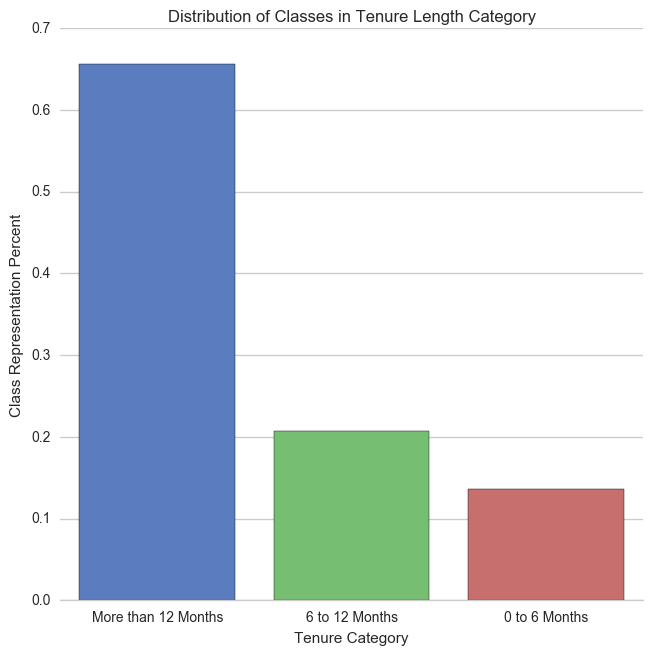

In [44]:
class_dist = pd.DataFrame(df_applicants_hires.tenure_length_category.value_counts() / float(df_applicants_hires.shape[0]))
class_dist = class_dist.reset_index()
class_dist.columns = ['tenure_length_category', 'total_percentage']
plot_group(data=class_dist, x='tenure_length_category', y='total_percentage', xlab='Tenure Category', 
           ylab='Class Representation Percent', title='Distribution of Classes in Tenure Length Category', kind='bar')

The first and most important step in building our prediction model is preparing the data to be used in training and testing. We perform a number of transformations on the variables in our dataset to end up with a __(1107, 147)__ mulidimensional array of independent variables and a __ (1107,1)__ array of target variable.

We then split our data into training and testing sets with _80%_ of the data used in training and _20%_ testing.


In [52]:
# Preparing data for modeling and splitting into train and test sets
X, y, class_desc = DataLoadTransform.prepare_data_for_modeling(df_applicants_hires)
X_train, y_train, X_test, y_test = DataLoadTransform.split_test_train(X, y)
(X.shape, y.shape)

((1107, 147), (1107,))

Below, we are tuning three different prediction algorithms, Random Forest, Logistic Regression and Support Vector Machines, with different combinations of parameters. For each algorithm, we select the model with the best performing combination of parameters. Once we select the parameters for each algorithm, we then perform a 10-fold cross validation to find the model with the highest accuracy score and train and make predictions on our test dataset that we set aside.

The consistantly best performing algorithm turned out to Random Forest in predicting Tenure Length Category. Random Forest as an ensemble learning algorithm is expected to perform better than most other learning algorithms, especially on survey like datasets with large number of dimensions. Random Forest creates a number of dummy trees that the algorithm trains and averages their prediction probabilities to come up with a final probabilistic prediction - allowing it to come up with a more accurate class probabilities. 

In [53]:
# Initializing the model object and tuning the default models (Random Forest, Logistic Regression and Support Vector Machines)
# Once we tune each of the models (using grid search), we perform a 10-fold cross validation to find the best model
model = Model(X_train, y_train, X_test, y_test)
clfs_tuned = model.tune_model()
best_clf = model.train_model(clfs=clfs_tuned)
# We train the best performing model (Random Forest performed consistantly better than the others)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

In [54]:

# Once we have the predictions, we can see the confusion matrix, precision, recall and F1-scores below
print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0,1,2])))
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_desc))

   0   1    2
0  7   0   28
1  1  11   18
2  3   7  147
                     precision    recall  f1-score   support

      0 to 6 Months       0.64      0.20      0.30        35
     6 to 12 Months       0.61      0.37      0.46        30
More than 12 Months       0.76      0.94      0.84       157

        avg / total       0.72      0.74      0.70       222



Notice that we have an f1-score of 70% which is quite good considering the size of our sample. However, we can always improve our model using a number of techniques. 

Looking at the classification table above, we can see that our model has a serious issue with recall when it comes to the first and second classes, while it performs excellently when predicting the third class. Perhaps, this could be due to the over-representation of the third class in our dataset. As we saw in the class distribution figure above, 65% of the samples in our data have third class (More than 12 Months) in the target variable. This makes it likely that more often than not, the model predicts this class than the others. 89% of the predictions are for class 3. A majority of the errors are caused by this type of misclassification.    

To imporove our model we can try any of the following:

- Collecting/Adding more training data (Most important)
- Tuning the model even more exhaustively by cross validating using extensive combinations of parameters
- Generating more examples of the underrepresented classes ( in this case, examples with classes 1 and 2)
- We can also try dimensionality reduction techniques like PCA or matrix factorization and make predictions using the top 10/20/etc principal components/latent variables.

Despite the errors, this is still a good model that the organizations can take advantage of in their decision to hire applicants. This, combined with other tools, techniques and intuition used at the Human Resource of our clients will certainly allow them to pick applicants that will most likely stay with the company for a long time.